1. Сделать гетерогенный граф по Вашему датасету и идее
     
     узлы – это факты и диалоги. Между фактами мы составляем узлы, если семантическая близость у них высокая, и также составляем узлы между фактами и диалогами, если факты встречаются в диалоге, что-то вроде co-occurence в этом случае получается
2. Попробовать обучить нейросеть так, чтобы предлагались похожие факты на основе приходящих на вход реплик (?)
3. Сделать датасет с базовой информацией о пользователях (возраст, пол...), который мы получаем при логине пользователя в наше приложение. Как-то его совместить с персоной/мультисешн
4. На основе этой информации через нейросеть получить факты, которые потом используем в генерации

In [1]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sentence_transformers import SentenceTransformer
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

c:\Users\Alex\scoop\apps\python\3.12.6\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Выделить уникальные факты
Косинусная близость фактов с диалогами --> связи между фактом и диалогом
Семантическая близость фактов между собой --> связь между фактами

In [2]:
data = pd.read_csv('personachat\personality.csv')

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Alex\AppData\Local\Temp\ipykernel_4908\2899807865.py:1: SyntaxWarning: invalid escape sequence '\p'
  data = pd.read_csv('personachat\personality.csv')


In [ ]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embed = model.encode

In [ ]:
punctuation.join('.')
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
wn = WordNetLemmatizer()
def stemmer(sent):
    tokenized_sentence = word_tokenize(sent)
    tokenized_sentence = ' '.join([wn.lemmatize(token) for token in tokenized_sentence if token not in punctuation])
    return tokenized_sentence

In [ ]:
unique_facts = []
for row in data['Persona']:
    tokenized_row = sent_tokenize(row)
    for fact in tokenized_row:
        fact = stemmer(fact)
        fact = fact.split(".")
        for i in fact:
            if i not in unique_facts:
                unique_facts.append(i)
len(unique_facts)

4874

In [ ]:
facts_set = pd.DataFrame()
facts_set['facts'] = unique_facts

In [ ]:
from tqdm import tqdm

facts_embeds = []
for i in tqdm(range(len(unique_facts))):
    facts_embeds.append(embed(unique_facts[i]))

facts_set['facts embeddings'] = facts_embeds

100%|██████████| 4874/4874 [02:14<00:00, 36.24it/s]


In [ ]:
import torch.nn

In [ ]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
b =torch.from_numpy(np.stack(facts_set['facts embeddings'].values))

similar_facts_dict = {}

for i in tqdm(range(len(facts_set['facts embeddings']))):
    similar_fact = []
    for j in range(i + 1, len(facts_set['facts embeddings'])):
        similarity_matrix_facts = cos(b[i], b[j])
        if similarity_matrix_facts > 0.5:
            similar_fact.append([j, facts_set['facts'].iloc[j]])
    similar_facts_dict[i] = similar_fact

facts_set['similar facts'] = similar_facts_dict.values()


100%|██████████| 4874/4874 [09:19<00:00,  8.71it/s] 


,facts,facts embeddings,similar facts
0,i like to remodel home,"[0.0051025893, 0.056571826, -0.0309115, -0.028...","[[75, i like to cook], [149, i enjoy building ..."
1,i like to go hunting,"[0.02298242, 0.078923084, -0.0019388765, -0.02...","[[2, i like to shoot a bow], [28, i like to li..."
2,i like to shoot a bow,"[0.013739883, 0.043460373, -0.004025144, -0.00...","[[50, i enjoy playing tennis], [65, i like to ..."
3,my favorite holiday is halloween,"[-0.049425937, 0.044676133, -0.030005446, 0.02...","[[25, halloween is my favorite holiday], [128,..."
4,my mom is my best friend,"[-0.026512254, 0.08790123, -0.00909354, 0.0103...","[[130, my best friend is my dog allie], [366, ..."
...,...,...,...
4869,i work 40 hour a week,"[-0.046944138, 0.040070456, -0.016525408, -0.0...",[]
4870,i write,"[0.027530022, 0.052740976, 0.024295546, -0.010...",[]
4871,i m italian american,"[-0.06824845, 0.088562965, -0.016663581, 0.019...",[]
4872,i drive a moped,"[-0.012356686, 0.052373253, 0.036497135, -0.00...",[]


0.5 вообще совсем плохо, не подходит

In [ ]:
similar_facts_dict = {}

for i in tqdm(range(len(facts_set['facts embeddings']))):
    similar_fact = []
    for j in range(i + 1, len(facts_set['facts embeddings'])):
        similarity_matrix_facts = cos(b[i], b[j])
        if similarity_matrix_facts > 0.8:
            similar_fact.append([j, facts_set['facts'].iloc[j]])
    similar_facts_dict[i] = similar_fact

facts_set['similar facts'] = similar_facts_dict.values()

facts_set.head()

100%|██████████| 4874/4874 [03:50<00:00, 21.18it/s] 


,facts,facts embeddings,similar facts
0,i like to remodel home,"[0.0051025893, 0.056571826, -0.0309115, -0.028...",[]
1,i like to go hunting,"[0.02298242, 0.078923084, -0.0019388765, -0.02...","[[82, i like to hunt], [1156, i love to hunt],..."
2,i like to shoot a bow,"[0.013739883, 0.043460373, -0.004025144, -0.00...",[]
3,my favorite holiday is halloween,"[-0.049425937, 0.044676133, -0.030005446, 0.02...","[[25, halloween is my favorite holiday], [128,..."
4,my mom is my best friend,"[-0.026512254, 0.08790123, -0.00909354, 0.0103...","[[3401, my mom is my favorite person of all pe..."
...,...,...,...
4869,i work 40 hour a week,"[-0.046944138, 0.040070456, -0.016525408, -0.0...",[]
4870,i write,"[0.027530022, 0.052740976, 0.024295546, -0.010...",[]
4871,i m italian american,"[-0.06824845, 0.088562965, -0.016663581, 0.019...",[]
4872,i drive a moped,"[-0.012356686, 0.052373253, 0.036497135, -0.00...",[]


In [ ]:
similar_facts_dict = {}

for i in tqdm(range(len(facts_set['facts embeddings']))):
    similar_fact = []
    for j in range(i + 1, len(facts_set['facts embeddings'])):
        similarity_matrix_facts = cos(b[i], b[j])
        if similarity_matrix_facts > 0.75:
            similar_fact.append([j, facts_set['facts'].iloc[j]])
    similar_facts_dict[i] = similar_fact

facts_set['similar facts'] = similar_facts_dict.values()

100%|██████████| 4874/4874 [03:30<00:00, 23.14it/s] 


In [ ]:
print(facts_set['facts'][3117], '\n')
for i in similar_facts_dict[3117]:
    print(i, sep = '\n')

i live in california 

[3732, 'i live in upstate new york']
[4239, 'i live in texas']
[4272, 'i live in toronto canada']
[4331, 'i live in north dakota']
[4408, 'i live in new york city']


In [ ]:
facts_set.head()

,facts,facts embeddings,similar facts
0,i like to remodel home,"[0.0051025893, 0.056571826, -0.0309115, -0.028...",[]
1,i like to go hunting,"[0.02298242, 0.078923084, -0.0019388765, -0.02...","[[82, i like to hunt], [1156, i love to hunt],..."
2,i like to shoot a bow,"[0.013739883, 0.043460373, -0.004025144, -0.00...",[]
3,my favorite holiday is halloween,"[-0.049425937, 0.044676133, -0.030005446, 0.02...","[[25, halloween is my favorite holiday], [128,..."
4,my mom is my best friend,"[-0.026512254, 0.08790123, -0.00909354, 0.0103...","[[3401, my mom is my favorite person of all pe..."


Следующий вариант как будто самый лучший

In [ ]:
similar_facts_dict = {}

for i in tqdm(range(len(facts_set['facts embeddings']))):
    similar_fact = []
    for j in range(i + 1, len(facts_set['facts embeddings'])):
        similarity_matrix_facts = cos(b[i], b[j])
        if similarity_matrix_facts > 0.7:
            similar_fact.append([j, facts_set['facts'].iloc[j]])
    similar_facts_dict[i] = similar_fact

facts_set['similar facts'] = similar_facts_dict.values()

facts_set.head()

100%|██████████| 4874/4874 [03:30<00:00, 23.18it/s] 


,facts,facts embeddings,similar facts
0,i like to remodel home,"[0.0051025893, 0.056571826, -0.0309115, -0.028...","[[1833, i like to refurbish classic car]]"
1,i like to go hunting,"[0.02298242, 0.078923084, -0.0019388765, -0.02...","[[2, i like to shoot a bow], [82, i like to hu..."
2,i like to shoot a bow,"[0.013739883, 0.043460373, -0.004025144, -0.00...","[[82, i like to hunt], [1156, i love to hunt],..."
3,my favorite holiday is halloween,"[-0.049425937, 0.044676133, -0.030005446, 0.02...","[[25, halloween is my favorite holiday], [128,..."
4,my mom is my best friend,"[-0.026512254, 0.08790123, -0.00909354, 0.0103...","[[1495, my sister is my best friend], [3401, m..."


интересные параллели даже в самом 1, что remodel homes близко к refurbishing cars
и объединение hunting с shooting a bow

In [ ]:
dialog_embeddings = model.encode(data['chat'], convert_to_tensor=True)

In [ ]:
fact_to_dialog_dict = {}

for i in tqdm(range(len(facts_set['facts embeddings']))):
    fact_to_dialog = []
    for j in range(len(dialog_embeddings)):
        similarity_matrix_fact_dialog= cos(b[i], dialog_embeddings[j])
        if similarity_matrix_fact_dialog > 0.2:
            fact_to_dialog.append([j])
    fact_to_dialog_dict[i] = fact_to_dialog

facts_set['fact to dialog connection'] = fact_to_dialog_dict.values()

facts_set.head()

100%|██████████| 4874/4874 [27:33<00:00,  2.95it/s]


,facts,facts embeddings,similar facts,fact to dialog connection
0,i like to remodel home,"[0.0051025893, 0.056571826, -0.0309115, -0.028...","[[1833, i like to refurbish classic car]]","[[5], [17], [18], [33], [49], [55], [64], [69]..."
1,i like to go hunting,"[0.02298242, 0.078923084, -0.0019388765, -0.02...","[[2, i like to shoot a bow], [82, i like to hu...","[[0], [4], [5], [8], [9], [10], [11], [15], [1..."
2,i like to shoot a bow,"[0.013739883, 0.043460373, -0.004025144, -0.00...","[[82, i like to hunt], [1156, i love to hunt],...","[[0], [4], [10], [19], [29], [31], [33], [35],..."
3,my favorite holiday is halloween,"[-0.049425937, 0.044676133, -0.030005446, 0.02...","[[25, halloween is my favorite holiday], [128,...","[[0], [5], [66], [71], [152], [172], [173], [1..."
4,my mom is my best friend,"[-0.026512254, 0.08790123, -0.00909354, 0.0103...","[[1495, my sister is my best friend], [3401, m...","[[1], [2], [5], [11], [13], [14], [17], [18], ..."


In [ ]:
print(facts_set['facts'][3], '\n')

print(data['chat'][5], sep = '\n')

my favorite holiday is halloween 

hello friend , how is it going
i am well an you ? i have a creepy ride . guess
i am great enjoying the football season
i drive around in a long black hearse an love this season
you work for a funeral home ?
yes it is nice , halloween is my fav .
lol , i can imagine . i will be reading a lot when football is over
no i do not work at a funeral home
ok i see , that is your halloween costume
what do you like to read ? i like rock alternative music .
i like anything to do with mystery
oh no it is not it is my car lol
lol , oh i see , taught you own it
me also what is your favorite ?
well i like sherlock holmes and others
i do own it i think there is confusion ?



вообще вроде работает...

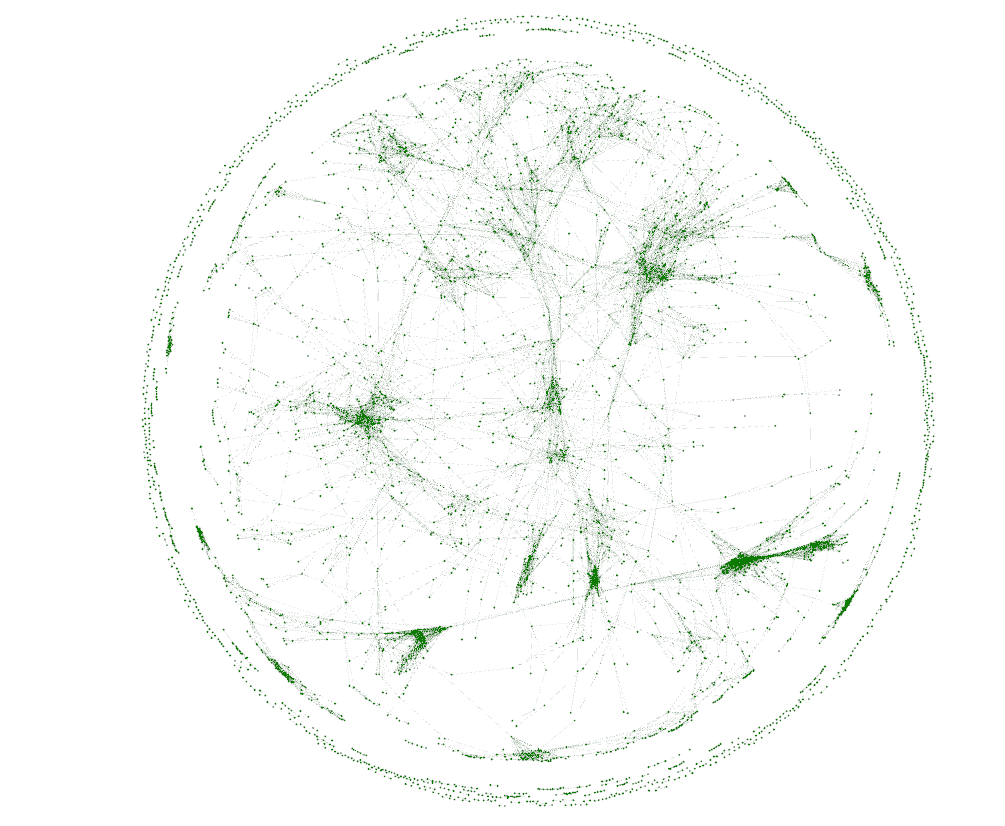

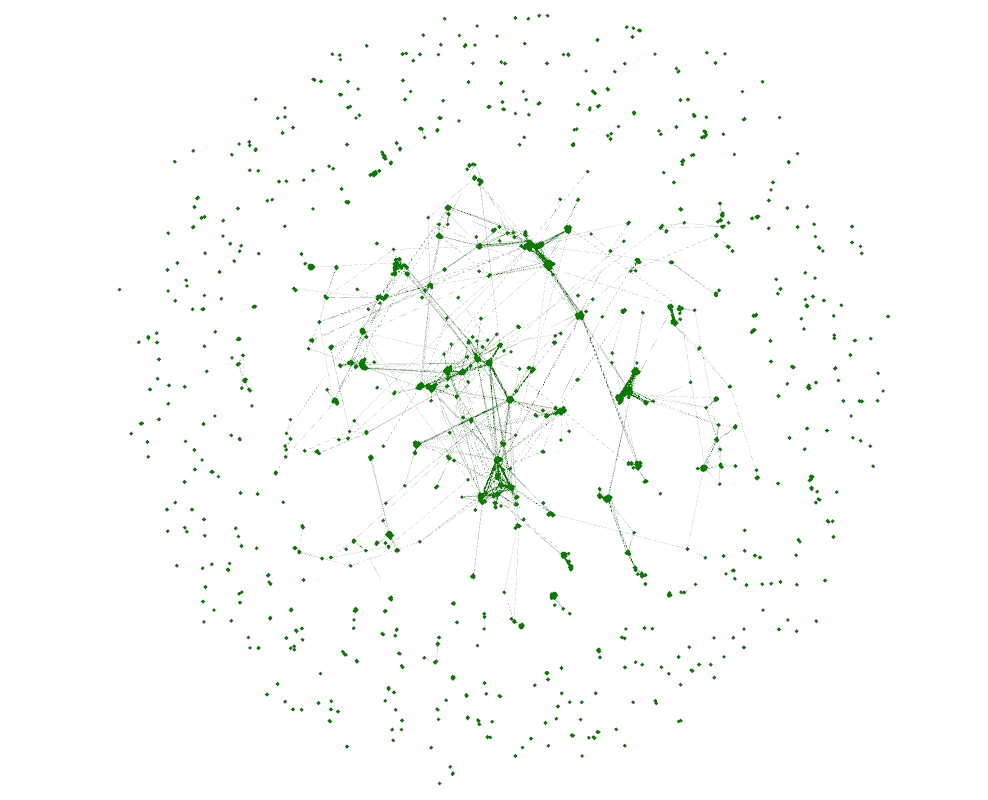